In [1]:
from symred.symplectic_form import PauliwordOp
from symred.S3_projection import (S3_projection, 
                                  gf2_gaus_elim, 
                                  gf2_basis_for_gf2_rref, 
                                  QubitTapering, 
                                  CS_VQE, 
                                  CheatS_VQE)

In [2]:
import numpy as np
import openfermion as of
import openfermionpyscf as ofpyscf

# comment out due to incompatible versions of Cirq and OpenFermion in Orquestra
def QubitOperator_to_dict(op, num_qubits):
    assert(type(op) == of.QubitOperator)
    op_dict = {}
    term_dict = op.terms
    terms = list(term_dict.keys())

    for t in terms:    
        letters = ['I' for i in range(num_qubits)]
        for i in t:
            letters[i[0]] = i[1]
        p_string = ''.join(letters)        
        op_dict[p_string] = term_dict[t]
         
    return op_dict

# Two examples are provided -- comment out as necessary

# One for which Hartree-Fock identifies the correct symmetry sector...
geometry=[
    ("F",(0,0,0)),
    ("H",(0.952519,0,0)),
    #("H",(-0.246530058,0.9200627021,0))
]

# ...and one for which it does not.
#geometry=[
#    ('H', (0.0,0.0,0.0)),
#    ('H', (2.45366053071732,0.0,0.0)),
#    #('H', (2.45366053071732,2.45366053071732,0.0)),
#    #('H', (0.0,2.45366053071732,0.0))
#     ]    
    
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
#molecule.load()

# Run pyscf.
molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=0,run_cisd=0,run_ccsd=0,run_fci=0)

n_qubits    = 2*molecule.n_orbitals
n_electrons = molecule.n_electrons

ham_fermionic = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_jw = of.jordan_wigner(ham_fermionic)

ham_dict = QubitOperator_to_dict(ham_jw, n_qubits)

print('Jordan-Wigner Hamiltonian:\n\n', ham_dict)

Jordan-Wigner Hamiltonian:

 {'IIIIIIIIIIII': (-60.82915378963077+0j), 'ZIIIIIIIIIII': (16.18024198177899+0j), 'YZYIIIIIIIII': (0.167633333377052+0j), 'XZXIIIIIIIII': (0.167633333377052+0j), 'YZZZYIIIIIII': (-0.04336072808867338+0j), 'XZZZXIIIIIII': (-0.04336072808867338+0j), 'YZZZZZZZZZYI': (-0.057608998626446334+0j), 'XZZZZZZZZZXI': (-0.057608998626446334+0j), 'IZIIIIIIIIII': (16.18024198177899+0j), 'IYZYIIIIIIII': (0.16763333337705205+0j), 'IXZXIIIIIIII': (0.16763333337705205+0j), 'IYZZZYIIIIII': (-0.04336072808867338+0j), 'IXZZZXIIIIII': (-0.04336072808867338+0j), 'IYZZZZZZZZZY': (-0.057608998626446334+0j), 'IXZZZZZZZZZX': (-0.057608998626446334+0j), 'IIZIIIIIIIII': (2.335858508883514+0j), 'IIYZYIIIIIII': (0.160834790573428+0j), 'IIXZXIIIIIII': (0.160834790573428+0j), 'IIYZZZZZZZYI': (0.2752996630713063+0j), 'IIXZZZZZZZXI': (0.2752996630713063+0j), 'IIIZIIIIIIII': (2.3358585088835135+0j), 'IIIYZYIIIIII': (0.16083479057342795+0j), 'IIIXZXIIIIII': (0.16083479057342795+0j), 'IIIYZZZZZ

In [4]:
from openfermion import FermionOperator, jordan_wigner
hf_state = np.concatenate([np.ones(n_electrons, dtype=int),np.zeros(n_qubits-n_electrons, dtype=int)])

def sor_data():
        """ Calculate the w(i) function 
        as in https://arxiv.org/pdf/1406.4920.pdf
        """
        w = {i:0 for i in range(n_qubits)}
        for f_op,coeff in ham_fermionic.terms.items():
            if len(f_op)==2:
                (p,p_ex),(q,q_ex) = f_op
                # self-interaction terms p==q
                if p==q:
                    w[p] += coeff
            if len(f_op)==4:
                (p,p_ex),(q,q_ex),(r,r_ex),(s,s_ex) = f_op
                #want p==r and q==s for hopping
                if p==r:
                    if q==s and hf_state[q]==1:
                        w[p]+=coeff
        return w
    
def second_order_response():
        """ Calculate the I_a Hamiltonian term importance metric 
        as in https://arxiv.org/pdf/1406.4920.pdf
        """
        w = sor_data()
        f_out = FermionOperator()
        for H_a,coeff in ham_fermionic.terms.items():
            if len(H_a)==4:
                (p,p_ex),(q,q_ex),(r,r_ex),(s,s_ex) = H_a
                Delta_pqrs = abs(w[p]+w[q]-w[r]-w[s])
                if Delta_pqrs == 0:
                    I_a = 1e15
                else:
                    I_a = (abs(coeff)**2)/Delta_pqrs
                
                f_out += FermionOperator(H_a, I_a)
        f_out_jw = jordan_wigner(f_out)
        f_out_q = QubitOperator_to_dict(f_out_jw, n_qubits)
        return f_out_q
    
sor_ham = PauliwordOp({op:coeff for op, coeff in second_order_response().items() if op in ham_dict})
sor_ham.coeff_vec/=np.max(sor_ham.coeff_vec)
print(sor_ham)

(1+0j) IIIIIIIIIIII +
(-0.17828422004412214+0j) ZIIIIIIIIIII +
(-0.17828422004412214+0j) IZIIIIIIIIII +
(0.036587744520163404+0j) ZZIIIIIIIIII +
(7.890891152488829e-20+0j) YZYIIIIIIIII +
(-7.956743643392099e-20+0j) YIYIIIIIIIII +
(7.890891152488829e-20+0j) XZXIIIIIIIII +
(-7.956743643392099e-20+0j) XIXIIIIIIIII +
(7.605763155671377e-21+0j) YZZZYIIIIIII +
(-7.435508929656173e-21+0j) YIZZYIIIIIII +
(7.605763155671377e-21+0j) XZZZXIIIIIII +
(-7.435508929656173e-21+0j) XIZZXIIIIIII +
(7.795947918807591e-21+0j) YZZZZZZZZZYI +
(-7.734836487975497e-21+0j) YIZZZZZZZZYI +
(7.795947918807591e-21+0j) XZZZZZZZZZXI +
(-7.734836487975497e-21+0j) XIZZZZZZZZXI +
(7.890891152488833e-20+0j) IYZYIIIIIIII +
(-7.956743643392099e-20+0j) ZYZYIIIIIIII +
(7.890891152488833e-20+0j) IXZXIIIIIIII +
(-7.956743643392099e-20+0j) ZXZXIIIIIIII +
(0.009154252905133197+0j) YXXYIIIIIIII +
(-0.009154252905133197+0j) YYXXIIIIIIII +
(-0.009154252905133197+0j) XXYYIIIIIIII +
(0.009154252905133197+0j) XYYXIIIIIIII +
(-1.60232

In [5]:
mol_op = PauliwordOp(ham_dict)

In [6]:
import scipy

def get_ground_state(sparse_operator, initial_guess=None):
    """Compute lowest eigenvalue and eigenstate.
    Args:
        sparse_operator (LinearOperator): Operator to find the ground state of.
        initial_guess (ndarray): Initial guess for ground state.  A good
            guess dramatically reduces the cost required to converge.
    Returns
    -------
        eigenvalue:
            The lowest eigenvalue, a float.
        eigenstate:
            The lowest eigenstate in scipy.sparse csc format.
    """
    values, vectors = scipy.sparse.linalg.eigsh(sparse_operator,
                                                k=1,
                                                v0=initial_guess,
                                                which='SA',
                                                maxiter=1e7)

    order = np.argsort(values)
    values = values[order]
    vectors = vectors[:, order]
    eigenvalue = values[0]
    eigenstate = vectors[:, 0]
    return eigenvalue, eigenstate.T

In [7]:
mol_op = PauliwordOp(ham_dict)
print(get_ground_state(mol_op.to_sparse_matrix)[0])
hf_state = np.concatenate([np.ones(n_electrons, dtype=int),np.zeros(n_qubits-n_electrons, dtype=int)])
qtap = QubitTapering(mol_op)
taper_mol_op = qtap.taper_it(ref_state=hf_state)
taper_sor_op = qtap.taper_it(aux_operator=sor_ham, ref_state=hf_state)
true_gs = get_ground_state(taper_mol_op.to_sparse_matrix)[0]
print(true_gs)

print(taper_sor_op)

-98.60149411679053
-98.60149411678977
(1.073175489040327+0j) IIIIIIII +
(-0.09195961910000171+0j) IIIIIIIZ +
(-0.09195961910000171+0j) IIIIIIZI +
(0.036587744520163404+0j) IIIIIIZZ +
(-0.3587897813812142+0j) IIIIIZII +
(0.006525238493921849+0j) IIIIIZIZ +
(0.006525238493921849+0j) IIIIIZZI +
(-0.3587897813812142+0j) IIIIZIII +
(0.006525238493921853+0j) IIIIZIIZ +
(0.006525238493921853+0j) IIIIZIZI +
(0.07317548904032681+0j) IIIIZZII +
(-0.19182793695685765+0j) IIIZIIII +
(0.00427936692881901+0j) IIIZIIIZ +
(0.004609847427221587+0j) IIIZIIZI +
(0.036587744520163404-0j) IIIZIZII +
(0.036587744520163404-0j) IIIZZIII +
(-0.003702413088098987+0j) IIIZZZIZ +
(-0.19182793695685765+0j) IIZIIIII +
(0.004609847427221587+0j) IIZIIIIZ +
(0.00427936692881901+0j) IIZIIIZI +
(0.036587744520163404+0j) IIZIIZII +
(0.036587744520163404+0j) IIZIZIII +
(-0.003702413088098987+0j) IIZIZZZI +
(0.036587744520163404+0j) IIZZIIII +
(-0.17913844251780414+0j) IZIIIIII +
(0.0035009698039329467+0j) IZIIIIIZ +
(0.00

In [8]:
print(taper_mol_op.to_dictionary)

{'IIIIIIII': (-60.330396976665945+0j), 'IIIIIIIZ': (1.2019077557648337+0j), 'IIIIIIZI': (1.2019077557648337+0j), 'IIIIIIZZ': (0.17812014158581005+0j), 'IIIIIZII': (3.9554886773667217+0j), 'IIIIIZIZ': (0.31729775267744653+0j), 'IIIIIZZI': (0.31729775267744653+0j), 'IIIIZIII': (3.9554886773667235+0j), 'IIIIZIIZ': (0.31729775267744664+0j), 'IIIIZIZI': (0.31729775267744664+0j), 'IIIIZZII': (0.8630877006840607+0j), 'IIIZIIII': (1.7452172441099334+0j), 'IIIZIIIZ': (0.12247709879657817+0j), 'IIIZIIZI': (0.16726133918154826+0j), 'IIIZIZII': (0.36368707254617116+0j), 'IIIZZIII': (0.3636870725461713+0j), 'IIIZZZIZ': (-0.2815394643467638+0j), 'IIZIIIII': (1.7452172441099336+0j), 'IIZIIIIZ': (0.16726133918154826+0j), 'IIZIIIZI': (0.12247709879657817+0j), 'IIZIIZII': (0.36368707254617116+0j), 'IIZIZIII': (0.3636870725461713+0j), 'IIZIZZZI': (-0.2815394643467638+0j), 'IIZZIIII': (0.19057238225834533+0j), 'IZIIIIII': (2.3358585088835135+0j), 'IZIIIIIZ': (0.14586924971101528+0j), 'IZIIIIZI': (0.170038

In [10]:
from itertools import product, combinations
from symred.symplectic_form import StabilizerOp

print(np.sum(np.square(taper_mol_op.coeff_vec)))
ref_state = qtap.taper_reference_state(hf_state)
cheat = CheatS_VQE(operator=taper_mol_op, ref_state=ref_state, target_sqp='X')

N=4
reconum,commute,sor_sum,abs_sum,errors = [],[],[],[],[]
samples=[]
for comb in range(100):
    Z_block = np.random.randint(0,2,(N, taper_mol_op.n_qubits))
    basis_symp = np.hstack([np.zeros_like(Z_block), Z_block])
    try:
        basis = StabilizerOp(basis_symp, np.ones(N))
        projected = cheat.project_onto_subspace(basis)
        nrg = get_ground_state(projected.to_sparse_matrix)[0]
        
        sor_val = cheat.weighted_objective(basis, taper_sor_op)
        abs_val = cheat.weighted_objective(basis)
        sor_sum.append(sor_val)
        abs_sum.append(abs_val)
        commute.append(np.count_nonzero(np.all(taper_sor_op.commutes_termwise(basis), axis=1)))
        errors.append(nrg-true_gs)
        reconum.append(np.count_nonzero(taper_mol_op.basis_reconstruction(basis)))
        samples.append([basis, nrg-true_gs])
    except:
        pass

basis, error = sorted(samples, key=lambda x:x[1])[0]
print(error)
print(basis)

(4223.161913514544+0j)
0.005225126170444128
(1+0j) ZZIZIZIZ +
(1+0j) ZZZZIIZZ +
(1+0j) IIZIIZIZ +
(1+0j) IIZIZIIZ


Text(0, 0.5, 'error')

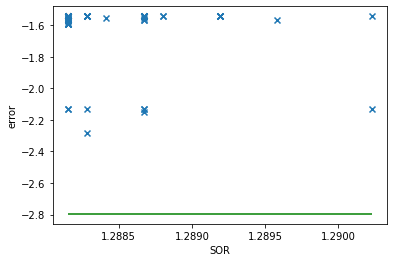

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(sor_sum,np.log10(errors), marker='x')
ax.hlines(np.log10(0.0016), min(sor_sum), max(sor_sum), color='green')
ax.set_xlabel('SOR')
ax.set_ylabel('error')
#ax.set_zlabel('error')

In [24]:
from functools import reduce
sor_sort_indices = np.argsort(-abs(taper_sor_op.coeff_vec))
sor_sort = [taper_sor_op[int(i)] for i in sor_sort_indices if ~np.all(taper_sor_op[int(i)].X_block==0)]
sor_sort = reduce(lambda x,y:x+y, sor_sort[:50])

In [25]:
basis = StabilizerOp({'ZZIIIIZZ':1, 'IIZZIIII':1, 'IIIIIIZZ':1, 'IIIIIZII':1})
print(cheat.weighted_objective(basis, aux_operator=sor_sort))
projected = cheat.project_onto_subspace(basis)
nrg = get_ground_state(projected.to_sparse_matrix)[0]
nrg-true_gs

(0.07974650318193487+0j)


0.005177470143877372

In [30]:
for comb in range(100):
    Z_block = np.random.randint(0,2,(N, taper_mol_op.n_qubits))
    basis_symp = np.hstack([np.zeros_like(Z_block), Z_block])
    try:
        basis = StabilizerOp(basis_symp, np.ones(N))
        print(cheat.weighted_objective(basis, aux_operator=sor_sort))
        projected = cheat.project_onto_subspace(basis)
        nrg = get_ground_state(projected.to_sparse_matrix)[0]
        print(nrg-true_gs)
        print()
    except:
        pass

0j
0.026447769115165443

(0.00033048049840257775+0j)
0.007443814995951925

0j
0.02865805605686944

(0.036587744520163404+0j)
0.02865805605701155

(0.036587744520163404+0j)
0.02864887692761897

0j
0.02865805605702576

0j
(0.04481294242021126+0j)
0.02787813411752893

0j
0.028658056056812597

(0.05174814816085567+0j)
0.027266766097667983

(0.05174819851825206+0j)
0.025692967752789286

(0.018296128134992023+0j)
0j
0.027267706668496317

(0.018296128134992023+0j)
0.0286488772370177

0j
0.02865805605716787

0j
0j
0.02865805605684102

(0.0409128883614602+0j)
0.028658056056954706

(0.05174288451705697+0j)
0.027267707615692416

(0.036587744520163404+0j)
0.028656519065862085

(0.036587744520163404+0j)
0.02865651906608946

0j
0.028658056056912073

0j
0.028658056056897863

(0.01829722532386744+0j)
0.02864633962136054

(0.018299112603945338+0j)
0.007443753468493242

(0.018308505810266395+0j)
0.027888478768176128

0j
0.0286580560566847

(0.036587744520163404+0j)
0.02865651906577682

(0.00033048049840

In [214]:
bases,err = zip(*samples)

In [215]:
for op,e,s in sorted(list(zip(bases, err, sor_sum)), key=lambda x:-x[2]):
    print(e)
    print(op)
    print(s)
    print()

0.032755977253629
(1+0j) IIIIIIIIZZ +
(1+0j) ZZIZZIIZZZ +
(1+0j) IZZZIZZIIZ
(1.4448956533682078+0j)

0.02903623286988477
(1+0j) ZIZIZIIIIZ +
(1+0j) ZZIIIZIIZZ +
(1+0j) ZZIZZZIIZZ
(1.4448956087602618+0j)

0.027246605252798872
(1+0j) ZZIIIZIZII +
(1+0j) ZIZIZZZIZI +
(1+0j) ZIZZIZZZIZ
(1.4448956087518678+0j)

0.031315975830494835
(1+0j) IZZZZIZZIZ +
(1+0j) ZZIIZZIZZZ +
(1+0j) IZZIIIIIZI
(1.4423638227657516+0j)

0.034169849630202975
(1+0j) IIIZIIIIII +
(1+0j) ZIZZIIZZZI +
(1+0j) ZZIZZZIZZZ
(1.4423638196973017+0j)

0.03120453344888574
(1+0j) IIIZIIZIII +
(1+0j) IZZZIZIIIZ +
(1+0j) IZZIIZIIIZ
(1.4410979687933418+0j)

0.032422481559862604
(1+0j) IZZIZZIZIZ +
(1+0j) IZZIZZIIZI +
(1+0j) IIZZIZZIZI
(1.4410979262681338+0j)

0.03279337787355985
(1+0j) IIZIZIIZIZ +
(1+0j) ZIZZIIIIIZ +
(1+0j) ZZZIZIZZZI
(1.4410979251739464+0j)

0.027917701353530333
(1+0j) IIIIZIZZZZ +
(1+0j) ZIZZZIIZZI +
(1+0j) ZIZIZIIIZI
(1.4410979251739464+0j)

0.032805058408570176
(1+0j) ZZIZZZZIII +
(1+0j) ZZZZIZIIIZ +
(1+0j) IZ

In [181]:
list(zip(X, Y))

[((1.6205311112289769+0j), 0.040061754629444835),
 ((1.6205311112289769+0j), 0.01838480871253978),
 ((1.6205311233956081+0j), 0.04013610249319299),
 ((1.6205311112289769+0j), 0.040276318246700527),
 ((1.6205311112289769+0j), 0.018464002253196554),
 ((1.6205311112289769+0j), 0.040276318246711185),
 ((1.6205311112289769+0j), 0.04013901786177243),
 ((1.6205311112289769+0j), 0.04013901786182217),
 ((1.6205311233956081+0j), 0.0002810878310377518),
 ((1.6205311112289769+0j), 0.040276318246739606),
 ((1.6205311112289769+0j), 0.04013610249315036),
 ((1.6205311112289769+0j), 0.018464002253253398),
 ((1.6205311112289769+0j), 0.0002810878310057774),
 ((1.6205311112289769+0j), 0.01846013977788985),
 ((1.6205311112289769+0j), 0.040059541430586876),
 ((1.6205311112289769+0j), 0.040059922831026995),
 ((1.6205311233956081+0j), 0.018352961652404076),
 ((1.6205311112289769+0j), 0.04027631824667566),
 ((1.6205311112289769+0j), 0.04013436913564661),
 ((1.6205311112289769+0j), 0.040276318246672105),
 ((1.6

In [213]:
projected = cheat.project_onto_subspace(basis)
nrg = get_ground_state(projected.to_sparse_matrix)[0]
print(basis)
print(nrg-true_gs)

(1+0j) IZZIZIZIZI +
(1+0j) ZIZZIIIZZI +
(1+0j) IZIZZZIIZI
0.027158055340166243


In [43]:
taper_mol_op.commutes_termwise(basis)

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ Tr

In [377]:
print(len(list(combinations(range(2**10), r=3))))
len([a for a in list(combinations(range(2**10), r=3)) if
    check_independent(bin_to_basis(a))])

178433024


KeyboardInterrupt: 

In [364]:
def check_independent(matrix):
    reduced = gf2_gaus_elim(matrix)
    return ~np.any(np.all(reduced==0, axis=1))

def bin_to_basis(basis_indices):
    rows = []
    for index in list(basis_indices):
        binary = format(int(index), f'010b')
        row = np.array([int(i) for i in binary], dtype=int)
        rows.append(row)
    basis_symp = np.vstack(rows)
    return basis_symp
    
        
bin_to_basis([1,2,4])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [271]:
bin_set = list(product([0,1], repeat=10))[1:]
np.random.random_sample(bin_set)

ValueError: maximum supported dimension for an ndarray is 32, found 1023

In [211]:
def func(basis_index):
    basis_index = np.round(basis_index)
    print(basis_index)
    rows = []
    for index in list(basis_index):
        binary = format(int(index), f'010b')
        row = np.array([int(i) for i in binary], dtype=int)
        rows.append(row)
    basis_symp = np.vstack(rows)
    basis = StabilizerOp(basis_symp, np.ones(basis_symp.shape[0]))
    return -cheat.commuting_objective(basis)

from scipy.optimize import minimize

minimize(func, x0=np.array([3,30,18]), method='powell', options={'maxiter':100})

[ 3. 30. 18.]
[ 3. 30. 18.]
[ 4. 30. 18.]
[ 6. 30. 18.]
[ 4. 30. 18.]
[ 5. 30. 18.]
[ 4. 30. 18.]
[ 4.+0.j 30.+0.j 18.+0.j]
[ 4.+0.j 30.+0.j 18.+0.j]
[ 4.+0.j 30.+0.j 18.+0.j]
[ 4.+0.j 30.+0.j 18.+0.j]
[ 4.+0.j 30.+0.j 18.+0.j]
[ 4.+0.j 30.+0.j 18.+0.j]
[ 4.+0.j 30.+0.j 18.+0.j]
[ 4.+0.j 30.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 33.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 32.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 18.+0.j]
[ 4.+0.j 31.+0.j 19.+0.j]
[ 4.+0.j 31.+0.j 21.+0.j]
[ 4.+0.j 31.+0.j 19.+0.j]
[ 4.+0.j 31.+0.j 20.+0.j]
[ 4.+0.j 31.+0.j 20.+0.j]
[ 4.+0.j 31.+0.j 20.+0.j]
[ 4.+0.j 31.+0.j 20.+0.j]
[ 4.+0.j 31.+0.j 20.+0.j]
[ 4.+0.j 31.+0.j 21.+0.j]
[ 4.+0.j 31.+0.j 20.+0.j]
[ 4.+0.j 31.+0.j 20.+0.j]


/tmp/ipykernel_69646/1111281084.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  binary = format(int(index), f'010b')


   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: (-87.26529826968189-0j)
 message: 'Optimization terminated successfully.'
    nfev: 39
     nit: 1
  status: 0
 success: True
       x: array([ 3.62867712+0.j, 30.62867712+0.j, 20.41331716+0.j])

In [212]:
np.triu(mat)

array([[1, 0, 0, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 1, 1]])

array([[1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1]])

In [135]:


def bases(N):
    single_op = list(product([0,1], repeat=8))
    bases = [np.array(comb) for comb in combinations(single_op, r=N) if 
            (np.all(np.einsum('ij->i',np.array(comb))!=0) and
             np.all(np.einsum('ij->j',np.array(comb))!=0))]
    return bases

N=2
errors = []
counter = 0
for basis_symp in bases(N):
    basis_symp = np.hstack([np.zeros_like(basis_symp), basis_symp])
    try:
        basis = StabilizerOp(basis_symp, np.ones(N, dtype=int))
        #print(basis)
        projected = cheat.project_onto_subspace(basis)
        nrg = get_ground_state(projected.to_sparse_matrix)[0]
        errors.append([basis, nrg-true_gs])
        print(counter)
    except:
        print('no', counter)
    counter+=1

no 0
no 1
no 2
no 3
no 4
no 5
no 6
no 7
no 8
no 9
no 10
no 11
no 12
no 13
no 14
no 15
no 16
no 17
no 18
no 19
no 20
no 21
no 22
no 23
no 24
no 25
no 26
no 27
no 28
no 29
no 30
no 31
no 32
no 33
no 34
no 35
no 36
no 37
no 38
no 39
no 40
no 41
no 42
no 43
no 44
no 45
no 46
no 47
no 48
no 49
no 50
no 51
no 52
no 53
no 54
no 55
no 56
no 57
no 58
no 59
no 60
no 61
no 62
no 63
no 64
no 65
no 66
no 67
no 68
no 69
no 70
no 71
no 72
no 73
no 74
no 75
no 76
no 77
no 78
no 79
no 80
no 81
no 82
no 83
no 84
no 85
no 86
no 87
no 88
no 89
no 90
no 91
no 92
no 93
no 94
no 95
no 96
no 97
no 98
no 99
no 100
no 101
no 102
no 103
no 104
no 105
no 106
no 107
no 108
no 109
no 110
no 111
no 112
no 113
no 114
no 115
no 116
no 117
no 118
no 119
no 120
no 121
no 122
no 123
no 124
no 125
no 126
no 127
no 128
no 129
no 130
no 131
no 132
no 133
no 134
no 135
no 136
no 137
no 138
no 139
no 140
no 141
no 142
no 143
no 144
no 145
no 146
no 147
no 148
no 149
no 150
no 151
no 152
no 153
no 154
no 155
no 156
no 157
no 1

no 1378
no 1379
no 1380
no 1381
no 1382
no 1383
no 1384
no 1385
no 1386
no 1387
no 1388
no 1389
no 1390
no 1391
no 1392
no 1393
no 1394
no 1395
no 1396
no 1397
no 1398
no 1399
no 1400
no 1401
no 1402
no 1403
no 1404
no 1405
no 1406
no 1407
no 1408
no 1409
no 1410
no 1411
no 1412
no 1413
no 1414
no 1415
no 1416
no 1417
no 1418
no 1419
no 1420
no 1421
no 1422
no 1423
no 1424
no 1425
no 1426
no 1427
no 1428
no 1429
no 1430
no 1431
no 1432
no 1433
no 1434
no 1435
no 1436
no 1437
no 1438
no 1439
no 1440
no 1441
no 1442
no 1443
no 1444
no 1445
no 1446
no 1447
no 1448
no 1449
no 1450
no 1451
no 1452
no 1453
no 1454
no 1455
no 1456
no 1457
no 1458
no 1459
no 1460
no 1461
no 1462
no 1463
no 1464
no 1465
no 1466
no 1467
no 1468
no 1469
no 1470
no 1471
no 1472
no 1473
no 1474
no 1475
no 1476
no 1477
no 1478
no 1479
no 1480
no 1481
no 1482
no 1483
no 1484
no 1485
no 1486
no 1487
no 1488
no 1489
no 1490
no 1491
no 1492
no 1493
no 1494
no 1495
no 1496
no 1497
no 1498
no 1499
no 1500
no 1501
no 1502


no 2421
no 2422
no 2423
no 2424
no 2425
no 2426
no 2427
no 2428
no 2429
no 2430
no 2431
no 2432
no 2433
no 2434
no 2435
no 2436
no 2437
no 2438
no 2439
no 2440
no 2441
no 2442
no 2443
no 2444
no 2445
no 2446
no 2447
no 2448
no 2449
no 2450
no 2451
no 2452
no 2453
no 2454
no 2455
no 2456
no 2457
no 2458
no 2459
no 2460
no 2461
no 2462
no 2463
no 2464
no 2465
no 2466
no 2467
no 2468
no 2469
no 2470
no 2471
no 2472
no 2473
no 2474
no 2475
no 2476
no 2477
no 2478
no 2479
no 2480
no 2481
no 2482
no 2483
no 2484
no 2485
no 2486
no 2487
no 2488
no 2489
no 2490
no 2491
no 2492
no 2493
no 2494
no 2495
no 2496
no 2497
no 2498
no 2499
no 2500
no 2501
no 2502
no 2503
no 2504
no 2505
no 2506
no 2507
no 2508
no 2509
no 2510
no 2511
no 2512
no 2513
no 2514
no 2515
no 2516
no 2517
no 2518
no 2519
no 2520
no 2521
no 2522
no 2523
no 2524
no 2525
no 2526
no 2527
no 2528
no 2529
no 2530
no 2531
no 2532
no 2533
no 2534
no 2535
no 2536
no 2537
no 2538
no 2539
no 2540
no 2541
no 2542
no 2543
no 2544
no 2545


[<symred.symplectic_form.StabilizerOp object at 0x7fda3ced3df0>, 0.0005044761680004228]


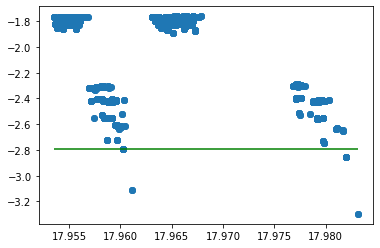

In [27]:
from matplotlib import pyplot as plt
sort_errors = sorted(errors, key=lambda x:x[1])
print(sort_errors[0])
chem_acc = [basis for basis, error in sort_errors if error<0.0016]
X1,X2,Y=[],[],[]
for basis, error in sort_errors:
    Y.append(error)
    #print(basis)
    ss = (np.sum(np.square(taper_mol_op.coeff_vec[np.all(taper_mol_op.commutes_termwise(basis), axis=1)])))
    nc = (np.count_nonzero(np.all(taper_mol_op.commutes_termwise(basis), axis=1)))
    
    X1.append(ss)
    X2.append(nc/ss)
    #print()

plt.scatter(X1, np.log10(Y))
plt.hlines(np.log10(0.0016), np.min(X1), np.max(X1), color='green')

In [31]:
for row in list(zip(X, Y)):
    print(row)

((279.00415983889116+0j), 0.0002810878310874898)
((279.00415983889116+0j), 0.0002810878310910425)
((279.00415983889116+0j), 0.00028108783109459523)
((279.00415983889116+0j), 0.00028108783109814794)
((279.00415983889116+0j), 0.00028108783110170066)
((279.00415983889116+0j), 0.00028108783110525337)
((279.00415983889116+0j), 0.0002810878311123588)
((279.00415983889116+0j), 0.0002810878311159115)
((279.00415983889116+0j), 0.0002810878311194642)
((279.00415983889116+0j), 0.00028108783112301694)
((279.00415983889116+0j), 0.0002810878311372278)
((279.00068524822177+0j), 0.018464002253274714)
((279.00068524822177+0j), 0.018464002253285372)
((279.00068524822177+0j), 0.018464002253292477)
((279.00068524822177+0j), 0.01846400225329603)
((279.00068524822177+0j), 0.01846400225329603)
((279.00068524822177+0j), 0.01846400225329603)
((279.00068524822177+0j), 0.01846400225329603)
((279.00068524822177+0j), 0.01846400225329603)
((279.00068524822177+0j), 0.018464002253299583)
((279.00068524822177+0j), 0.0

In [ ]:
ref_state = qtap.taper_reference_state(hf_state)
cs_mol = CS_VQE(taper_mol_op, ref_state=ref_state, target_sqp='Z')
cs_mol.noncontextual_energy

In [ ]:
print(cs_mol.contextual_operator.to_dictionary)

In [ ]:
from itertools import combinations

for stab_indices in combinations([0,1,2,3,4], r=2):
    stab_indices = list(stab_indices)
    proj_ham = cs_mol.contextual_subspace_projection(stabilizer_indices=stab_indices)
    #print(proj_ham)
    nrg = get_ground_state(proj_ham.to_sparse_matrix)[0]
    print(nrg, nrg-true_gs)

In [ ]:
from symred.utils import to_indep_set

symmetry = cs_mol.decompose_noncontextual()['symmetry'].copy()
clique_0 = cs_mol.decompose_noncontextual()['clique_0']
C0 = clique_0[6]
for Ci in clique_0:
    symmetry+=C0*Ci
clique_1 = cs_mol.decompose_noncontextual()['clique_1']
C1 = clique_1[5]
for Ci in clique_1:
    symmetry+=C1*Ci

clique_operator = C0 + C1
symmetry_generators = PauliwordOp(
    dict(to_indep_set({op:[None] for op in symmetry.to_dictionary.keys()})[0])
)
basis = clique_operator+symmetry_generators
print(basis)

In [ ]:
from itertools import product, combinations
from symred.symplectic_form import StabilizerOp

def optimal():
    values = []
    for stab_indices in combinations([1,2,3,4], r=3):
        stab_indices = list(stab_indices)
        proj_ham = cs_mol.contextual_subspace_projection(stabilizer_indices=stab_indices)
        #print(proj_ham)
        nrg = get_ground_state(proj_ham.to_sparse_matrix)[0]
        values.append([stab_indices, nrg-true_gs])
    return sorted(values, key=lambda x:x[1])[0]

single_op = list(product([0,1], repeat=4))
bases = [np.array([a,b,c,d]) for a,b,c,d in combinations(single_op, r=4) if 
            (np.all(np.einsum('ij->i',np.array([a,b,c,d]))!=0) and
             np.all(np.einsum('ij->j',np.array([a,b,c,d]))!=0))]

cs_vqe_errors=[]
for mat in bases:
    mat = np.hstack([mat[:,:1], np.zeros_like(mat[:,:1]), mat[:,1:]])
    #print(mat)
    try:
        basis = StabilizerOp(np.hstack([np.zeros_like(mat), mat]), np.ones(4))
        basis+=StabilizerOp({'IXIII':1,'IZIII':1})
        basis = StabilizerOp(basis.to_dictionary)
        basis.coeff_vec = np.ones(6, dtype=int)
        cs_mol.update_basis(basis)
        stab_indices, energy = optimal()
        cs_vqe_errors.append([basis, stab_indices, energy])
    except:
        pass

In [ ]:
X=[]
Y=[]
for op,sind,energy in sorted(cs_vqe_errors, key=lambda x:x[2]):
    #print(energy)
    #print(sind)
    #print(op)
    Y.append(energy)
    X.append(np.count_nonzero(np.all(cs_mol.contextual_operator.commutes_termwise(op)[:,sind],axis=1)))
    #print()

from matplotlib import pyplot as plt

plt.scatter(X,Y)

In [ ]:
basis = PauliwordOp({
    'ZIZZZ':1, 
    'ZIZIZ':1, 
    'ZIZZI':1, 
    'IIZZZ':1,
    'ZXZZI':1,
    'IZIZZ':1
})
cs_mol.update_basis(basis)
cs_mol.noncontextual_energy

In [ ]:
print(cs_mol.symmetry_generators)
print()
print(cs_mol.clique_operator)
print()
print(cs_mol.rotated_stabilizers)

In [ ]:
print(cs_mol.symmetry_generators)
print()
print(cs_mol.clique_operator)
cs_mol.noncontextual_energy

In [ ]:
C0 = cs_mol.clique_representatives[0]
C1 = cs_mol.clique_representatives[1]

rot = (C0*C1).multiply_by_constant(-1j)
angle = np.arctan(C0.coeff_vec/C1.coeff_vec)
#if you wish to rotate onto +1 eigenstate:
if abs(C1.coeff_vec+np.cos(angle)) < 1e-15:
    angle += np.pi
print((cs_mol.clique_representatives._rotate_by_single_Pword(rot, angle)).cleanup_zeros())

In [ ]:
p=1.00001
r_vec = np.array([np.sqrt(1/p), np.sqrt((p-1)/p)])
nu_vec = np.array([-1,1,1,1])

r_indices = cs_mol.noncontextual_reconstruction[:,:cs_mol.n_cliques]
G_indices = cs_mol.noncontextual_reconstruction[:,cs_mol.n_cliques:]

def noncontextual_objective_function(nu_vec, r_vec):
    """
    """
    G_prod = (-1)**np.count_nonzero(np.logical_and(G_indices==1, nu_vec == -1), axis=1)
    r_part = np.sum(r_indices*r_vec, axis=1)
    r_part[np.where(r_part==0)]=1
    return np.sum(cs_mol.noncontextual_operator.coeff_vec*G_prod*r_part).real

def convex_problem(theta):
    nu_vec = np.array([-1,1,1,1])
    r_vec = np.array([np.sin(theta), np.cos(theta)]).T
    return noncontextual_objective_function(nu_vec, r_vec)

noncontextual_objective_function(nu_vec, r_vec)

In [ ]:
theta=1
np.array([np.sin(theta), np.cos(theta)])

In [ ]:
from scipy.optimize import minimize, minimize_scalar

opt_out = minimize_scalar(convex_problem)
print(opt_out)
theta = opt_out['x']
noncontextual_energy = opt_out['fun']
theta, noncontextual_energy

In [ ]:
# order the basis so clique terms appear at the beginning
basis = cs_mol.noncontextual_symmetry_generators
basis_order = np.lexsort(basis.adjacency_matrix)
basis = PauliwordOp(basis.symp_matrix[basis_order],np.ones(basis.n_terms))
n_cliques = np.count_nonzero(~np.all(basis.adjacency_matrix, axis=1))
# note the first two columns will never both be 1... definition of noncontextual set!
# where the 1 appears determines which clique the term is in
print(basis.adjacency_matrix)
reconstruction = cs_mol.noncontextual_operator.basis_reconstruction(basis)
mask_non_universal, clique_index = np.where(reconstruction[:,0:n_cliques])
mask_universal = np.where(np.all(reconstruction[:,0:n_cliques]==0, axis=1)) 

decomposed = {}
univ_symp = cs_mol.noncontextual_operator.symp_matrix[mask_universal]
univ_coef = cs_mol.noncontextual_operator.coeff_vec[mask_universal]
decomposed['symmetry'] = PauliwordOp(univ_symp, univ_coef)

for i in np.unique(clique_index):
    mask_clique = clique_index==i
    Ci_symp = cs_mol.noncontextual_operator.symp_matrix[mask_non_universal][mask_clique]
    Ci_coef = cs_mol.noncontextual_operator.coeff_vec[mask_non_universal][mask_clique]
    decomposed[f'clique_{i}'] = PauliwordOp(Ci_symp, Ci_coef)

print(decomposed['clique_1'])

In [ ]:
print(decomposed['clique_0'])

In [ ]:
symmetry = cs_mol.decompose_noncontextual['symmetry'].copy()

clique_0 = cs_mol.decompose_noncontextual['clique_0']
C0 = clique_0[0]
for Ci in clique_0:
    symmetry+=C0*Ci

clique_1 = cs_mol.decompose_noncontextual['clique_1']
C1 = clique_1[0]
for Ci in clique_1:
    symmetry+=C1*Ci
    
print(symmetry)

In [ ]:
from symred.utils import to_indep_set

In [ ]:
print(cs_mol.noncontextual_symmetry_generators)

In [ ]:
print(QubitTapering(cs_mol.noncontextual_operator).symmetry_generators)

In [ ]:
from symred.symplectic_form import StabilizerOp
def symmetry_generators(op):
    """ Find an independent basis for the input operator symmetry
    """
    # swap order of XZ blocks in symplectic matrix to ZX
    ZX_symp = np.hstack([op.Z_block, op.X_block])
    reduced = gf2_gaus_elim(ZX_symp)
    kernel  = gf2_basis_for_gf2_rref(reduced)

    return StabilizerOp(kernel, np.ones(kernel.shape[0]))

print(symmetry_generators(cs_mol.decompose_noncontextual['universal']))

In [ ]:
S3_projection(symmetry_generators(cs_mol.decompose_noncontextual['universal']))

In [ ]:
basis = QubitTapering(cs_mol.decompose_noncontextual['universal']).symmetry_generators
print(basis)

In [ ]:
cs_mol.noncontextual_operator.basis_reconstruction(basis)

In [ ]:
def J_term(sqp, N):
    q_pos = list(range(N))
    make_sqp = list(zip(q_pos[:-1], q_pos[1:]))
    out = []
    for i,j in make_sqp:
        blank = list('I'*N)
        blank[i],blank[j]=sqp,sqp
        out.append(''.join(blank))
    return out

def h_terms(N):
    make_Z = list(range(N))
    out = []
    for i in make_Z:
        blank = list('I'*N)
        blank[i]='Z'
        out.append(''.join(blank))
    return out

N=8
terms=[]
for sqp in ['X', 'Y', 'Z']:
    terms+=J_term(sqp, N)
terms+=h_terms(N)


heisenberg = {op:1 for op in terms}
heisenberg_op = PauliwordOp(heisenberg)
qtap = QubitTapering(heisenberg_op)
print(qtap.symmetry_generators)

In [ ]:
print(get_ground_state(heisenberg_op.to_sparse_matrix)[0])
project_op = qtap.taper_it(sector=[-1])
print(get_ground_state(project_op.to_sparse_matrix)[0])

In [ ]:
class CS_VQE(S3_projection):
    pass

In [ ]:
def commute(x,y):
    assert len(x)==len(y), print(x,y)
    s = 1
    for i in range(len(x)):
        if x[i]!='I' and y[i]!='I' and x[i]!=y[i]:
            s = s*(-1)
    if s==1:
        return 1
    else:
        return 0

def contextualQ_ham(ham,verbose=False):
    S = list(ham.keys())
    # Store T all elements of S that anticommute with at least one other element in S (takes O(|S|**2) time).                                                                        
    T=[]
    Z=[] # complement of T                                                                                                                                                           
    for i in range(len(S)):
        if any(not commute(S[i],S[j]) for j in range(len(S))):
            T.append(S[i])
        else:
            Z.append(S[i])
    # Search in T for triples in which exactly one pair anticommutes; if any exist, S is contextual.                                                                                 
    for i in range(len(T)): # WLOG, i indexes the operator that commutes with both others.                                                                                           
        for j in range(len(T)):
            for k in range(j,len(T)): # Ordering of j, k does not matter.                                                                                                            
                if i!=j and i!=k and commute(T[i],T[j]) and commute(T[i],T[k]) and not commute(T[j],T[k]):
                    return True
    if verbose:
        return False,Z,T
    else:
        return False
op_dict = {'II':1,'XY':1,'XX':1, 'ZZ':1, 'YX':1, 'ZX':1}
print(contextualQ_ham(op_dict))

test = PauliwordOp(op_dict)
adj_mat = np.array(test.adjacency_matrix, dtype=int)
adj_mat
#where_commutes_universally = ~np.all(adj_mat, axis=1)
#remove_universally_commuting = adj_mat[where_commutes_universally,:][:,where_commutes_universally]
#remove_universally_commuting

In [ ]:
def condense_array(in_array):
    # order lexicographically and take difference between adjacent rows
    term_ordering = np.lexsort(in_array.T)
    diff_adjacent = np.diff(in_array[term_ordering], axis=0)
    # the unique terms are those which are non-zero
    mask_unique_terms = np.append(True, ~np.all(diff_adjacent==0, axis=1))
    # drop duplicate terms
    out_array = in_array[term_ordering,:][:,term_ordering][mask_unique_terms,:][:,mask_unique_terms]
    return out_array

In [ ]:
def is_contextual(op):
    adj_mat = np.array(op.adjacency_matrix, dtype=int)
    condensed = condense_array(adj_mat)
    print(condensed)
    return ~np.all(condensed[::-1].diagonal())

is_contextual(test)

In [ ]:
mol_op_dict = mol_op.to_dictionary
%timeit contextualQ_ham(mol_op_dict)

In [ ]:
from datetime import datetime
from datetime import timedelta

def contextualQ(S,verbose=False):
    # Store T all elements of S that anticommute with at least one other element in S (takes O(|S|**2) time).
    T=[]
    Z=[] # complement of T
    for i in range(len(S)):
        if any(not commute(S[i],S[j]) for j in range(len(S))):
            T.append(S[i])
        else:
            Z.append(S[i])
    # Search in T for triples in which exactly one pair anticommutes; if any exist, S is contextual.
    for i in range(len(T)): # WLOG, i indexes the operator that commutes with both others.
        for j in range(len(T)):
            for k in range(j,len(T)): # Ordering of j, k does not matter.
                if i!=j and i!=k and commute(T[i],T[j]) and commute(T[i],T[k]) and not commute(T[j],T[k]):
                    if verbose:
                        return [True,None,None]
                    else:
                        return True
    if verbose:
        return [False,Z,T]
    else:
        return False
    
def greedy_dfs(ham,cutoff,criterion='weight'):
    
    weight = {k:abs(ham[k]) for k in ham.keys()}
    possibilities = [k for k, v in sorted(weight.items(), key=lambda item: -item[1])] # sort in decreasing order of weight
    
    best_guesses = [[]]
    stack = [[[],0]]
    start_time = datetime.now()
    delta = timedelta(seconds=cutoff)
    
    i = 0
    
    while datetime.now()-start_time < delta and stack:
        
        while i < len(possibilities):
#             print(i)
            next_set = stack[-1][0]+[possibilities[i]]
#             print(next_set)
#             iscontextual = contextualQ(next_set)
#             print('  ',iscontextual,'\n')
            if not contextualQ(next_set):
                stack.append([next_set,i+1])
            i += 1
        
        if criterion == 'weight':
            new_weight = sum([abs(ham[p]) for p in stack[-1][0]])
            old_weight = sum([abs(ham[p]) for p in best_guesses[-1]])
            if new_weight > old_weight:
                best_guesses.append(stack[-1][0])
                # print(len(stack[-1][0]))
                # print(stack[-1][0],'\n')
            
        if criterion == 'size' and len(stack[-1][0]) > len(best_guesses[-1]):
            best_guesses.append(stack[-1][0])
            # print(len(stack[-1][0]))
            # print(stack[-1][0],'\n')
            
        top = stack.pop()
        i = top[1]
    
    return best_guesses

In [ ]:
print(greedy_dfs(taper_mol_op.to_dictionary, cutoff=1)[-1])

In [ ]:
from quantumtools.Hamiltonian import QubitHamiltonian, HamiltonianGraph

In [ ]:
HamiltonianGraph(QubitHamiltonian(taper_mol_op.to_dictionary))

In [ ]:
terms, coeffs = zip(*taper_mol_op.to_dictionary.items())
terms, coeffs = list(terms), list(coeffs)
graph = HamiltonianGraph(terms, coeffs)
g_dict = graph.clique_cover('AC', 'largest_first')
largest_AC_set = sorted(g_dict.items(), key=lambda x:-x[1].n_terms)[0][1]

In [ ]:
print(largest_AC_set)

In [ ]:
from symred.symplectic_form import PauliwordOp
from symred.S3_projection import CS_VQE
op1 = PauliwordOp({'XX':1, 'YY':1j})
op2 = PauliwordOp({'XY':1, 'YY':1j})
print((op1-op2).cleanup_zeros())

In [ ]:
s=slice(0,5,2)

In [ ]:
test = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(test)

In [ ]:
test[:,[2,0]]